## Retail Sales By Industries

### Data Cleaning and Wrangling

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

In [2]:
# Reading file

retailsales=pd.read_csv('../../data/retailsalesbyIndustry/retailSalesbyIndustry.csv')

In [3]:
# Renaming columns as per required
retailsales.rename(columns = {'REF_DATE':'DATE', 
                                            'GEO':'LOCATION',
                                            'North American Industry Classification System (NAICS)':'INDUSTRY',
                                            'Adjustments':'ADJUSTMENTS'
                                           },inplace = True)

In [4]:
# Filtering columns as needed and extracting required columns
retailsales_filtered=retailsales[(retailsales['LOCATION'] == 'Canada') & 
                 (retailsales['INDUSTRY'] == 'Retail trade [44-45]')&
                 (retailsales['ADJUSTMENTS'] == 'Seasonally adjusted')&
                 (retailsales['DATE'] >= '2004-01')]
retailsales_final = retailsales_filtered[['DATE', 'VALUE']].copy()

#Changing data type of date
retailsales_final['DATE'] =  pd.to_datetime(retailsales_final['DATE'])
retailsales_final.reset_index(drop=True)

,DATE,VALUE
0,2004-01-01,27935993.0
1,2004-02-01,28719948.0
2,2004-03-01,28689514.0
3,2004-04-01,28254086.0
4,2004-05-01,28554094.0
...,...,...
213,2021-10-01,58218955.0
214,2021-11-01,58750669.0
215,2021-12-01,57919779.0
216,2022-01-01,59857374.0


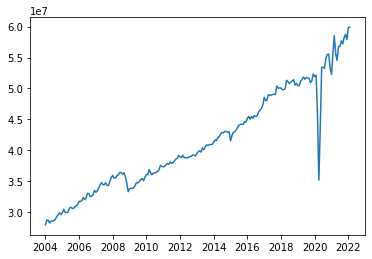

In [5]:
# plot

retailsales_date=retailsales_final.set_index('DATE')

plt.plot(retailsales_date)
plt.show()

## Getting predictors from Google trends

In [11]:
pytrends = TrendReq(hl='en-US', tz=360, backoff_factor=0.1)

In [14]:
def get_trend(keyword=[''], category='0'):
    """ Function for getting trends for selected keywords
        
        arguments: 
        
        Keywords: data type is string: stores list of keywords
        category: data type is string: stores the code for category
        
        returns: google trend data as a data frame  
    """
    
    kw_list=keyword
    cat=category
    timeframe='2004-01-01 2022-01-01'
    geo ='CA'
    gprop =''
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop)
    data = pytrends.interest_over_time()
    
    return data
    

In [17]:
keyword=["blockchain"]
data=get_trend(keyword=[''],category='841')


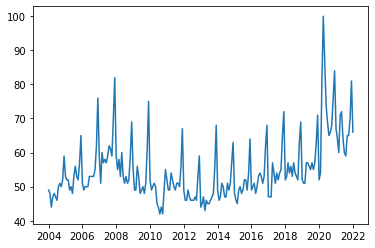

In [18]:
trend_data = data.copy()
plt.plot(trend_data[''])
plt.show()

In [82]:
# keywords = []

# all_keywords=['Fidget spinner','Food','Cycling','Home Alone','Delivery','Wine','Beer']

# cat = '22'
# geo = ''
# timeframes = ['today 5-y', 'today 12-m','today 3-m']
# gprop = ''

# def check_trends():
    
#     pytrends.build_payload(all_keywords, cat=0, timeframes[0], geo='CA', gprop)

#     data = pytrends.interest_over_time()
#     print(data)
    
# for kw in all_keywords:
#     keywords.append(kw)
#     check_trends()
#     keywords.pop()